In [259]:
import pandas as pd
import numpy as np
import hdbscan
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os
from tqdm import tqdm
import umap
from mpl_toolkits import mplot3d

import seaborn as sns

In [260]:
N_COMPONENTS = 5
INPUT_DIR = 'datasets/Anonimized/'

In [261]:
# stop_columns = ['№', 'Компатриоты', 'Unnamed: 4', 'Название команды', 'ФИО участников', 'ФИО', 'Компетенция', 'Баллы, ед.', 'Баллы по ключевым навыкам', 'Максимальное значение']
stop_columns = ['№', 'Компатриоты', 'Unnamed: 4', 'Название команды', 'ФИО участников', 'ФИО', 'Компетенция', 'Баллы, ед.', 'Баллы, %','Баллы по ключевым навыкам', 'Максимальное значение']

In [262]:
def data_prep(files_names):
    full_data = pd.DataFrame(columns=['ФИО', 'Компетенция'] + [f'feat_{i}' for i in range(N_COMPONENTS)])
    score = pd.DataFrame(columns=[0], index=None)
    scaler = StandardScaler()
    for filename in tqdm(files_names):
        data = pd.read_csv(INPUT_DIR + filename)
        if 'ФИО' in data.columns:
            fio = data['ФИО']
        else:
            fio = data['ФИО участников']
            data.rename(columns={'ФИО участников': 'ФИО'}, inplace=True)
        
        comp = data['Компетенция']
        
        if data['Баллы, %'].isna().sum() != 0 and data['Баллы, ед.'].isna().sum() == 0:
            data['Баллы, %'] = data['Баллы, ед.']
        elif data['Баллы, %'].isna().sum() != 0 and data['Баллы по ключевым навыкам'].isna().sum() == 0:
            data['Баллы, %'] = data['Баллы по ключевым навыкам']
        points_percent = data['Баллы, %'].apply(lambda x: x.replace(',','.').replace('%', '')).astype(float)
        points_alls = data['Баллы, ед.']
        try:
            if data['Баллы по ключевым навыкам'].dtype == 'object':
                points_skills = data['Баллы по ключевым навыкам'].apply(lambda x: x.replace(',','.').replace('%', '')).astype(float)
            else:
                points_skills = data['Баллы по ключевым навыкам']
        except:
            points_skills = data['Баллы ']
        data['Баллы, %'] = data['Баллы, %'].apply(lambda x: x.replace(',','.').replace('%', ''))
        score = pd.concat([data['Баллы, %'], score], axis=0)
        for column in stop_columns:
            if column in data.columns:
                data = data.drop(column, axis=1)
        data = data.dropna(axis=1, how='all')
        float_columns = data.select_dtypes(include=[object]).apply(lambda x: x.str.replace(',','.').str.replace('%', '')).astype(float)
        int_columns = data.select_dtypes(include=['int'])
        data = pd.concat([float_columns, int_columns], axis=1)
        data = pd.concat([data, data ** 2], axis=1)
        data = pd.concat([data, data ** 3], axis=1)
        data = scaler.fit_transform(data)
   
        data = np.nan_to_num(data, nan=0)
        pca = PCA(n_components=N_COMPONENTS)
        data_reduced = pca.fit_transform(data)
        data_reduced = pd.DataFrame(data_reduced, columns = [f'feat_{i}' for i in range(N_COMPONENTS)])
        data_reduced['ФИО'], data_reduced['Компетенция'] = fio, comp
        data_reduced['Баллы, ед.'] = points_alls
        data_reduced['Баллы, %'] = points_percent
        data_reduced['Баллы по ключевым навыкам'] = points_skills
        full_data = pd.concat([data_reduced, full_data], axis=0)
    full_data['score'] = scaler.fit_transform(score.to_numpy())

    return full_data

In [263]:
file_list = os.listdir(INPUT_DIR)
full_data = data_prep(file_list)

100%|██████████| 39/39 [00:03<00:00, 10.27it/s]


In [264]:
full_data

,feat_0,feat_1,feat_2,feat_3,feat_4,ФИО,Компетенция,"Баллы, ед.","Баллы, %",Баллы по ключевым навыкам,score
0,-8.773867,15.660287,-6.820419,3.768748,7.417670e-15,ФИО_478; ФИО_123; ФИО_220,Бетонные строительные работы,100,77.88,77.88,1.698061
1,-10.640790,-7.892995,-5.107474,-12.713493,7.417670e-15,ФИО_330; ФИО_564; ФИО_573,Бетонные строительные работы,100,81.83,81.83,1.901835
2,-4.386014,1.194804,17.694813,0.497441,7.417670e-15,ФИО_175; ФИО_332; ФИО_344,Бетонные строительные работы,100,70.78,70.78,1.331783
3,0.248966,-11.574890,-4.258791,12.830327,7.417670e-15,ФИО_173; ФИО_617; ФИО_708,Бетонные строительные работы,100,63.23,63.23,0.942290
4,23.551706,2.612794,-1.508129,-4.383022,7.417670e-15,ФИО_205; ФИО_671; ФИО_674,Бетонные строительные работы,100,51.80,51.8,0.352634
...,...,...,...,...,...,...,...,...,...,...,...
4,-0.124593,5.549962,-6.236548,-5.811013,-9.123205e+00,ФИО_75; ФИО_236; ФИО_363; ФИО_383; ФИО_561; ФИ...,Управление жизненным циклом,"56,03",56.03,0.0,0.570853
5,-2.306616,-10.199309,-8.205812,-4.289795,-3.931401e+00,ФИО_165; ФИО_372; ФИО_413; ФИО_513; ФИО_568; Ф...,Управление жизненным циклом,"49,07",49.07,0.0,0.211797
6,-14.178294,4.045955,9.017322,7.348897,-1.132731e+00,ФИО_25; ФИО_224; ФИО_565; ФИО_574; ФИО_603; ФИ...,Управление жизненным циклом,"44,54",44.54,0.0,-0.021899
7,-11.907731,-0.952798,1.837922,1.410736,-1.882104e+00,ФИО_33; ФИО_66; ФИО_80; ФИО_234; ФИО_320; ФИО_...,Управление жизненным циклом,"42,69",42.69,0.0,-0.117337


In [265]:
# fd = full_data.iloc[:, 0:N_COMPONENTS]
fd = pd.concat([full_data.iloc[:, :N_COMPONENTS], full_data['score']], axis=1)
fd


,feat_0,feat_1,feat_2,feat_3,feat_4,score
0,-8.773867,15.660287,-6.820419,3.768748,7.417670e-15,1.698061
1,-10.640790,-7.892995,-5.107474,-12.713493,7.417670e-15,1.901835
2,-4.386014,1.194804,17.694813,0.497441,7.417670e-15,1.331783
3,0.248966,-11.574890,-4.258791,12.830327,7.417670e-15,0.942290
4,23.551706,2.612794,-1.508129,-4.383022,7.417670e-15,0.352634
...,...,...,...,...,...,...
4,-0.124593,5.549962,-6.236548,-5.811013,-9.123205e+00,0.570853
5,-2.306616,-10.199309,-8.205812,-4.289795,-3.931401e+00,0.211797
6,-14.178294,4.045955,9.017322,7.348897,-1.132731e+00,-0.021899
7,-11.907731,-0.952798,1.837922,1.410736,-1.882104e+00,-0.117337


In [266]:
minmax = MinMaxScaler(feature_range=(0,1))
columns = fd.columns
fd = minmax.fit_transform(fd)
fd = pd.DataFrame(fd, columns=columns)
fd

,feat_0,feat_1,feat_2,feat_3,feat_4,score
0,0.261411,0.686693,0.274381,0.396839,0.399191,0.863745
1,0.238762,0.333155,0.304638,0.113533,0.399191,0.908708
2,0.314643,0.469564,0.707410,0.340610,0.399191,0.782925
3,0.370874,0.277889,0.319629,0.552595,0.399191,0.696983
4,0.653575,0.490848,0.368216,0.256722,0.399191,0.566875
...,...,...,...,...,...,...
445,0.366342,0.534935,0.284694,0.232177,0.245181,0.615026
446,0.339870,0.298537,0.249910,0.258325,0.332825,0.535800
447,0.195846,0.512360,0.554134,0.458377,0.380070,0.484234
448,0.223392,0.437328,0.427319,0.356309,0.367419,0.463176


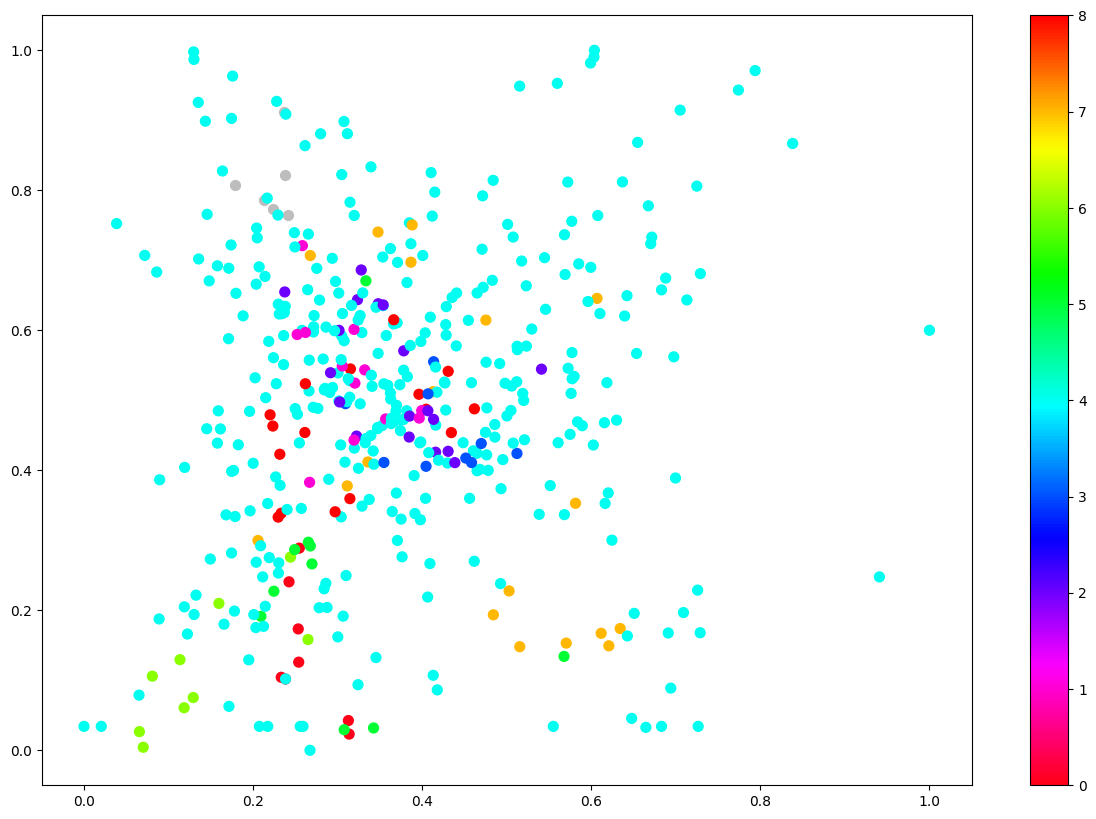

In [285]:
import matplotlib.pyplot as plt
# Подготовка данных\\

cluster = hdbscan.HDBSCAN(min_cluster_size=7, metric='euclidean', cluster_selection_method='eom').fit(fd)
fd['labels'] = cluster.labels_
# Визуализация кластеров
fig = plt.subplots(figsize=(15, 10))
outliers = fd.loc[fd.labels == -1, :]
clustered = fd.loc[fd.labels != -1, :]
# fig = plt.figure(figsize = (10, 7))
# ax = plt.axes(projection ="3d")
 
# # Creating plot
# ax.scatter3D(outliers.feat_0, outliers.feat_1, outliers.score, color='#BDBDBD', s=40)
# ax.scatter3D(clustered.feat_0, clustered.feat_1, clustered.score, c=clustered.labels, s=40, cmap='hsv_r')

plt.scatter(outliers.feat_0, outliers.score, color='#BDBDBD', s=50)
plt.scatter(clustered.feat_0, clustered.score, c=clustered.labels, s=50, cmap='hsv_r')

plt.colorbar()

In [286]:
full_data['labels'] = cluster.labels_
full_data['labels'].value_counts()

labels
 4    344
 7     18
 2     18
 8     16
 1     12
 5     10
 3      9
 6      9
 0      8
-1      6
Name: count, dtype: int64

In [287]:
full_data['labels'] = cluster.labels_
full_data.groupby(by='labels')['Баллы, %'].mean()

labels
-1    73.215000
 0    14.082500
 1    48.772500
 2    48.882222
 3    41.697778
 4    46.922469
 5    23.318000
 6    12.213333
 7    37.734444
 8    42.374375
Name: Баллы, %, dtype: float64

In [277]:
full_data.groupby(by='labels')['Баллы, %'].max()

labels
-1     33.00
 0     50.76
 1     22.00
 2     67.93
 3     89.85
 4     26.24
 5     42.69
 6     62.28
 7     56.03
 8     82.07
 9     27.37
 10    28.11
 11    49.38
 12    65.33
Name: Баллы, %, dtype: float64

In [184]:
full_data

,feat_0,ФИО,Компетенция,"Баллы, ед.","Баллы, %",Баллы по ключевым навыкам,score,labels
0,-8.773867,ФИО_478; ФИО_123; ФИО_220,Бетонные строительные работы,100,77.88,77.88,1.698061,13
1,-10.640790,ФИО_330; ФИО_564; ФИО_573,Бетонные строительные работы,100,81.83,81.83,1.901835,12
2,-4.386014,ФИО_175; ФИО_332; ФИО_344,Бетонные строительные работы,100,70.78,70.78,1.331783,-1
3,0.248966,ФИО_173; ФИО_617; ФИО_708,Бетонные строительные работы,100,63.23,63.23,0.942290,32
4,23.551706,ФИО_205; ФИО_671; ФИО_674,Бетонные строительные работы,100,51.80,51.8,0.352634,-1
...,...,...,...,...,...,...,...,...
4,-0.124593,ФИО_75; ФИО_236; ФИО_363; ФИО_383; ФИО_561; ФИ...,Управление жизненным циклом,"56,03",56.03,0.0,0.570853,41
5,-2.306616,ФИО_165; ФИО_372; ФИО_413; ФИО_513; ФИО_568; Ф...,Управление жизненным циклом,"49,07",49.07,0.0,0.211797,-1
6,-14.178294,ФИО_25; ФИО_224; ФИО_565; ФИО_574; ФИО_603; ФИ...,Управление жизненным циклом,"44,54",44.54,0.0,-0.021899,36
7,-11.907731,ФИО_33; ФИО_66; ФИО_80; ФИО_234; ФИО_320; ФИО_...,Управление жизненным циклом,"42,69",42.69,0.0,-0.117337,-1


In [185]:
full_data[full_data['labels'] == 1 ]

,feat_0,ФИО,Компетенция,"Баллы, ед.","Баллы, %",Баллы по ключевым навыкам,score,labels
2,25.984407,ФИО_182; ФИО_219; ФИО_356; ФИО_694,Инженерное проектирование,5,5.00,NaN,-2.061707,1
3,29.560775,ФИО_48; ФИО_63; ФИО_376; ФИО_456,Инженерное проектирование,5,5.00,NaN,-2.061707,1
8,26.887770,ФИО_68; ФИО_257,Управление качеством,100,9.80,9.8,-1.814082,1
11,23.074234,ФИО_494,Сварочные технологии,100,6.00,6.0,-2.010118,1
14,24.459176,ФИО_523,Сварочные технологии,100,4.88,4.88,-2.067897,1


In [186]:
participants_info = pd.read_csv('datasets/Участники anonimized.csv')
participants_info

,ФИО,Пол,Роль в мероприятии,Список компетенций,Должность,Категория,Начало трудового стажа,Место работы,Профессия,Дата рождения,Начало трудовой деятельности в РОСАТОМ,Образование,Место образования,Год оканчания,Специальность
0,ФИО_0,0,Участник мероприятия,Цифровое ПСР-Предприятие (Lean Smart Plant);,Инженер по подготовке производства,Инженер,1993-06-01,АО Чепецкий механический завод,Промышленная автоматика,1975-04-14,2001-01-25,NaN,NaN,NaN,NaN
1,ФИО_1,1,Участник мероприятия,Управление качеством;,Главный специалист,NaN,2000-08-01,Акционерное общество Научно-исследовательский...,NaN,1977-07-19,2021-09-14,NaN,NaN,NaN,NaN
2,ФИО_2,0,Участник мероприятия,Сварочные технологии;,Электрогазосварщик,NaN,NaN,"""Филиал Акционерного общества """"Русатом Инфрас...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ФИО_3,0,Участник мероприятия,Инженер-конструктор;,инженер-конструктор,NaN,июл.05,"""Акционерное Общество """"Машиностроительный зав...",NaN,23.06.1986,NaN,NaN,NaN,NaN,NaN
4,ФИО_4,0,Участник мероприятия,Геодезия;,Мастер-лаборант,NaN,NaN,ОБПОУ Курский монтажный техникум,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,ФИО_708,0,Участник мероприятия,Бетонные строительные работы;,Бетонщик,NaN,NaN,ООО Трест Рос Спец Энерго монтаж,NaN,NaN,NaN,NaN,NaN,NaN,NaN
709,ФИО_709,1,Участник мероприятия,Управление качеством;,Инженер по качеству,NaN,09.2013,"""ФГУП """"Приборостроительный завод""""""",NaN,22.06.1990,NaN,NaN,NaN,NaN,NaN
710,ФИО_710,1,Участник мероприятия,Аналитический контроль;,Лаборант химического анализа,NaN,2016-10-10,Центральная научно-исследовательская лаборатория,NaN,1993-02-01,2021-05-14,Высшее,ИрГУПС,2016,Эксплуатация железных дорог
711,ФИО_711,0,Участник мероприятия,Токарные работы на станках с ЧПУ;,токарь,NaN,NaN,"""АО """"Опытное Конструкторское Бюро Машинострое...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [187]:
from copy import copy
fd_fin = copy(full_data)
fd_fin

,feat_0,ФИО,Компетенция,"Баллы, ед.","Баллы, %",Баллы по ключевым навыкам,score,labels
0,-8.773867,ФИО_478; ФИО_123; ФИО_220,Бетонные строительные работы,100,77.88,77.88,1.698061,13
1,-10.640790,ФИО_330; ФИО_564; ФИО_573,Бетонные строительные работы,100,81.83,81.83,1.901835,12
2,-4.386014,ФИО_175; ФИО_332; ФИО_344,Бетонные строительные работы,100,70.78,70.78,1.331783,-1
3,0.248966,ФИО_173; ФИО_617; ФИО_708,Бетонные строительные работы,100,63.23,63.23,0.942290,32
4,23.551706,ФИО_205; ФИО_671; ФИО_674,Бетонные строительные работы,100,51.80,51.8,0.352634,-1
...,...,...,...,...,...,...,...,...
4,-0.124593,ФИО_75; ФИО_236; ФИО_363; ФИО_383; ФИО_561; ФИ...,Управление жизненным циклом,"56,03",56.03,0.0,0.570853,41
5,-2.306616,ФИО_165; ФИО_372; ФИО_413; ФИО_513; ФИО_568; Ф...,Управление жизненным циклом,"49,07",49.07,0.0,0.211797,-1
6,-14.178294,ФИО_25; ФИО_224; ФИО_565; ФИО_574; ФИО_603; ФИ...,Управление жизненным циклом,"44,54",44.54,0.0,-0.021899,36
7,-11.907731,ФИО_33; ФИО_66; ФИО_80; ФИО_234; ФИО_320; ФИО_...,Управление жизненным циклом,"42,69",42.69,0.0,-0.117337,-1


In [188]:
fd_fin['ФИО'] = fd_fin['ФИО'].str.split('; ')
fd_fin = fd_fin.explode('ФИО')
fd_fin['ФИО'] = fd_fin['ФИО'].str.strip()
fd_fin

,feat_0,ФИО,Компетенция,"Баллы, ед.","Баллы, %",Баллы по ключевым навыкам,score,labels
0,-8.773867,ФИО_478,Бетонные строительные работы,100,77.88,77.88,1.698061,13
0,-8.773867,ФИО_123,Бетонные строительные работы,100,77.88,77.88,1.698061,13
0,-8.773867,ФИО_220,Бетонные строительные работы,100,77.88,77.88,1.698061,13
1,-10.640790,ФИО_330,Бетонные строительные работы,100,81.83,81.83,1.901835,12
1,-10.640790,ФИО_564,Бетонные строительные работы,100,81.83,81.83,1.901835,12
...,...,...,...,...,...,...,...,...
8,-8.787423,ФИО_263,Управление жизненным циклом,"41,88",41.88,0.0,-0.159124,-1
8,-8.787423,ФИО_380,Управление жизненным циклом,"41,88",41.88,0.0,-0.159124,-1
8,-8.787423,ФИО_390,Управление жизненным циклом,"41,88",41.88,0.0,-0.159124,-1
8,-8.787423,ФИО_592,Управление жизненным циклом,"41,88",41.88,0.0,-0.159124,-1


In [189]:
general_df = pd.merge(left=fd_fin[['ФИО', 'labels']], right=participants_info, how='left', on='ФИО')
general_df

,ФИО,labels,Пол,Роль в мероприятии,Список компетенций,Должность,Категория,Начало трудового стажа,Место работы,Профессия,Дата рождения,Начало трудовой деятельности в РОСАТОМ,Образование,Место образования,Год оканчания,Специальность
0,ФИО_478,13,0.0,Участник мероприятия,Бетонные строительные работы;,Арматуршик,Специалист (рабочие специальности),2009-05-12,"АО ""концерн титан-2""",нет в предлагаемом списке,1985-05-19,2014-05-12,NaN,NaN,NaN,NaN
1,ФИО_123,13,0.0,Участник мероприятия,Бетонные строительные работы;,Арматурщик,Специалист (рабочие специальности),02.09.2015,Акционерное общество «Концерн Титан 2»,нет в предлагаемом списке,1993-05-02,2012-10-30,NaN,NaN,NaN,NaN
2,ФИО_220,13,0.0,Участник мероприятия,Бетонные строительные работы;,Монтажник,Специалист (рабочие специальности),2012-05-30,Титан 2,нет в предлагаемом списке,1991-02-23,2013-09-18,NaN,NaN,NaN,NaN
3,ФИО_330,12,0.0,Участник мероприятия,Бетонные строительные работы;,Монтажник,Специалист (рабочие специальности),2000-07-21,"АО ""Концерн Титан-2""",Электромонтаж,1986-10-23,2018-07-21,NaN,NaN,NaN,NaN
4,ФИО_564,12,0.0,Участник мероприятия,Бетонные строительные работы;,Монтажник по монтажу стальных и железобетонных...,Специалист (рабочие специальности),1997-06-22,"АО""КОНЦЕРН ТИТАН-2"" филиал ""СУС""",нет в предлагаемом списке,1975-08-02,2018-03-29,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,ФИО_263,-1,0.0,Участник мероприятия,Управление жизненным циклом;,Инженер-технолог,Инженер,2021-03-25,"филиал АО ""Концерн Росэнергоатом"" ""Калининская...",NaN,1997-11-16,2021-03-25,Полное высшее,Томский политехнический университет,2021,"14.05.02 Атомные станции: проектирование, эксп..."
708,ФИО_380,-1,0.0,Участник мероприятия,Управление жизненным циклом;,Инженер 1 категории по эксплуатации,Нет,2017-07-05,Калининском Атомная Электростанция,NaN,09.07.11931993-07-09,2017-07-05,Высшее,ТГТУ,2017,Электроэнергетика и электротехника
709,ФИО_390,-1,1.0,Участник мероприятия,Управление жизненным циклом;,Ведущий специалист,NaN,2020-10-05,"""АО """"Консист-Оператор-Связи""""""",NaN,1998-08-09,2020-10-05,высшее,ННГАСУ,2020,Архитектор-проектировщик
710,ФИО_592,-1,0.0,Участник мероприятия,Управление жизненным циклом;,Ведущий инженер по управлению реактором атомно...,NaN,03.05.2005,"""АО филиал концерна Росэнеогоатом """" калининск...",NaN,1990-07-10,2013-09-04,Высшее,ИГЭУ им. В.И. Ленина,2013,Атомные электрические станции и установки


In [190]:
general_df = pd.merge(left=fd_fin[['ФИО', 'labels']], right=participants_info, how='left', on='ФИО')
general_df

,ФИО,labels,Пол,Роль в мероприятии,Список компетенций,Должность,Категория,Начало трудового стажа,Место работы,Профессия,Дата рождения,Начало трудовой деятельности в РОСАТОМ,Образование,Место образования,Год оканчания,Специальность
0,ФИО_478,13,0.0,Участник мероприятия,Бетонные строительные работы;,Арматуршик,Специалист (рабочие специальности),2009-05-12,"АО ""концерн титан-2""",нет в предлагаемом списке,1985-05-19,2014-05-12,NaN,NaN,NaN,NaN
1,ФИО_123,13,0.0,Участник мероприятия,Бетонные строительные работы;,Арматурщик,Специалист (рабочие специальности),02.09.2015,Акционерное общество «Концерн Титан 2»,нет в предлагаемом списке,1993-05-02,2012-10-30,NaN,NaN,NaN,NaN
2,ФИО_220,13,0.0,Участник мероприятия,Бетонные строительные работы;,Монтажник,Специалист (рабочие специальности),2012-05-30,Титан 2,нет в предлагаемом списке,1991-02-23,2013-09-18,NaN,NaN,NaN,NaN
3,ФИО_330,12,0.0,Участник мероприятия,Бетонные строительные работы;,Монтажник,Специалист (рабочие специальности),2000-07-21,"АО ""Концерн Титан-2""",Электромонтаж,1986-10-23,2018-07-21,NaN,NaN,NaN,NaN
4,ФИО_564,12,0.0,Участник мероприятия,Бетонные строительные работы;,Монтажник по монтажу стальных и железобетонных...,Специалист (рабочие специальности),1997-06-22,"АО""КОНЦЕРН ТИТАН-2"" филиал ""СУС""",нет в предлагаемом списке,1975-08-02,2018-03-29,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,ФИО_263,-1,0.0,Участник мероприятия,Управление жизненным циклом;,Инженер-технолог,Инженер,2021-03-25,"филиал АО ""Концерн Росэнергоатом"" ""Калининская...",NaN,1997-11-16,2021-03-25,Полное высшее,Томский политехнический университет,2021,"14.05.02 Атомные станции: проектирование, эксп..."
708,ФИО_380,-1,0.0,Участник мероприятия,Управление жизненным циклом;,Инженер 1 категории по эксплуатации,Нет,2017-07-05,Калининском Атомная Электростанция,NaN,09.07.11931993-07-09,2017-07-05,Высшее,ТГТУ,2017,Электроэнергетика и электротехника
709,ФИО_390,-1,1.0,Участник мероприятия,Управление жизненным циклом;,Ведущий специалист,NaN,2020-10-05,"""АО """"Консист-Оператор-Связи""""""",NaN,1998-08-09,2020-10-05,высшее,ННГАСУ,2020,Архитектор-проектировщик
710,ФИО_592,-1,0.0,Участник мероприятия,Управление жизненным циклом;,Ведущий инженер по управлению реактором атомно...,NaN,03.05.2005,"""АО филиал концерна Росэнеогоатом """" калининск...",NaN,1990-07-10,2013-09-04,Высшее,ИГЭУ им. В.И. Ленина,2013,Атомные электрические станции и установки


In [160]:
general_df.to_csv('general_data.csv', index=False)

In [162]:
fd_fin[['ФИО', 'Баллы, ед.', 'Баллы, %', 'Баллы по ключевым навыкам', 'labels']].to_csv('names_and_score.csv', index=False)

In [164]:
general_df_2 = pd.merge(left=participants_info, right=fd_fin[['ФИО', 'Баллы, ед.', 'Баллы, %', 'Баллы по ключевым навыкам', 'labels']], how='left', on='ФИО').to_csv('general_and_score.csv', index=False)


In [167]:
fd.to_csv('scatter.csv', index=False)